In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

# Some utility functions we need for the class.
# For the class Data Science: Practical Deep Learning Concepts in Theano and TensorFlow
# https://deeplearningcourses.com/c/data-science-deep-learning-in-theano-tensorflow
# https://www.udemy.com/data-science-deep-learning-in-theano-tensorflow

# Note: run this from the current folder it is in.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


def get_clouds():
    Nclass = 500
    D = 2

    X1 = np.random.randn(Nclass, D) + np.array([0, -2])
    X2 = np.random.randn(Nclass, D) + np.array([2, 2])
    X3 = np.random.randn(Nclass, D) + np.array([-2, 2])
    X = np.vstack([X1, X2, X3])

    Y = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass)
    return X, Y


def get_spiral():
    # Idea: radius -> low...high
    #           (don't start at 0, otherwise points will be "mushed" at origin)
    #       angle = low...high proportional to radius
    #               [0, 2pi/6, 4pi/6, ..., 10pi/6] --> [pi/2, pi/3 + pi/2, ..., ]
    # x = rcos(theta), y = rsin(theta) as usual

    radius = np.linspace(1, 10, 100)
    thetas = np.empty((6, 100))
    for i in range(6):
        start_angle = np.pi*i / 3.0
        end_angle = start_angle + np.pi / 2
        points = np.linspace(start_angle, end_angle, 100)
        thetas[i] = points

    # convert into cartesian coordinates
    x1 = np.empty((6, 100))
    x2 = np.empty((6, 100))
    for i in range(6):
        x1[i] = radius * np.cos(thetas[i])
        x2[i] = radius * np.sin(thetas[i])

    # inputs
    X = np.empty((600, 2))
    X[:,0] = x1.flatten()
    X[:,1] = x2.flatten()

    # add noise
    X += np.random.randn(600, 2)*0.5

    # targets
    Y = np.array([0]*100 + [1]*100 + [0]*100 + [1]*100 + [0]*100 + [1]*100)
    return X, Y



def get_transformed_data():
    print("Reading in and transforming data...")

    if not os.path.exists('./train.csv'):
        print('Looking for ../large_files/train.csv')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: https://www.kaggle.com/c/digit-recognizer')
        print('Place train.csv in the folder large_files adjacent to the class folder')
        exit()

    df = pd.read_csv('./train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)

    X = data[:, 1:]
    mu = X.mean(axis=0)
    X = X - mu # center the data
    pca = PCA()
    Z = pca.fit_transform(X)
    Y = data[:, 0].astype(np.int32)

    plot_cumulative_variance(pca)

    return Z, Y, pca, mu


def get_normalized_data():
    print("Reading in and transforming data...")

    if not os.path.exists('./train.csv'):
        print('Looking for ../large_files/train.csv')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: https://www.kaggle.com/c/digit-recognizer')
        print('Place train.csv in the folder large_files adjacent to the class folder')
        exit()

    df = pd.read_csv('./train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std # normalize the data
    Y = data[:, 0]
    return X, Y


def plot_cumulative_variance(pca):
    P = []
    for p in pca.explained_variance_ratio_:
        if len(P) == 0:
            P.append(p)
        else:
            P.append(p + P[-1])
    plt.plot(P)
    plt.show()
    return P


def forward(X, W, b):
    # softmax
    a = X.dot(W) + b
    expa = np.exp(a)
    y = expa / expa.sum(axis=1, keepdims=True)
    return y


def predict(p_y):
    return np.argmax(p_y, axis=1)


def error_rate(p_y, t):
    prediction = predict(p_y)
    return np.mean(prediction != t)


def cost(p_y, t):
    tot = t * np.log(p_y)
    return -tot.sum()


def gradW(t, y, X):
    return X.T.dot(t - y)


def gradb(t, y):
    return (t - y).sum(axis=0)


def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind


def benchmark_full():
    X, Y = get_normalized_data()

    print("Performing logistic regression...")
    # lr = LogisticRegression(solver='lbfgs')

    # # test on the last 1000 points
    # lr.fit(X[:-1000, :200], Y[:-1000]) # use only first 200 dimensions
    # print lr.score(X[-1000:, :200], Y[-1000:])
    # print "X:", X

    # normalize X first
    # mu = X.mean(axis=0)
    # std = X.std(axis=0)
    # X = (X - mu) / std

    Xtrain = X[:-1000,]
    Ytrain = Y[:-1000]
    Xtest  = X[-1000:,]
    Ytest  = Y[-1000:]

    # convert Ytrain and Ytest to (N x K) matrices of indicator variables
    N, D = Xtrain.shape
    Ytrain_ind = y2indicator(Ytrain)
    Ytest_ind = y2indicator(Ytest)

    W = np.random.randn(D, 10) / np.sqrt(D)
    b = np.zeros(10)
    LL = []
    LLtest = []
    CRtest = []

    # reg = 1
    # learning rate 0.0001 is too high, 0.00005 is also too high
    # 0.00003 / 2000 iterations => 0.363 error, -7630 cost
    # 0.00004 / 1000 iterations => 0.295 error, -7902 cost
    # 0.00004 / 2000 iterations => 0.321 error, -7528 cost

    # reg = 0.1, still around 0.31 error
    # reg = 0.01, still around 0.31 error
    lr = 0.00004
    reg = 0.01
    for i in range(500):
        p_y = forward(Xtrain, W, b)
        # print "p_y:", p_y
        ll = cost(p_y, Ytrain_ind)
        LL.append(ll)

        p_y_test = forward(Xtest, W, b)
        lltest = cost(p_y_test, Ytest_ind)
        LLtest.append(lltest)
        
        err = error_rate(p_y_test, Ytest)
        CRtest.append(err)

        W += lr*(gradW(Ytrain_ind, p_y, Xtrain) - reg*W)
        b += lr*(gradb(Ytrain_ind, p_y) - reg*b)
        if i % 10 == 0:
            print("Cost at iteration %d: %.6f" % (i, ll))
            print("Error rate:", err)

    p_y = forward(Xtest, W, b)
    print("Final error rate:", error_rate(p_y, Ytest))
    iters = range(len(LL))
    plt.plot(iters, LL, iters, LLtest)
    plt.show()
    plt.plot(CRtest)
    plt.show()


def benchmark_pca():
    X, Y, _, _ = get_transformed_data()
    X = X[:, :300]

    # normalize X first
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mu) / std

    print("Performing logistic regression...")
    Xtrain = X[:-1000,]
    Ytrain = Y[:-1000]
    Xtest  = X[-1000:,]
    Ytest  = Y[-1000:]

    N, D = Xtrain.shape
    Ytrain_ind = np.zeros((N, 10))
    for i in range(N):
        Ytrain_ind[i, Ytrain[i]] = 1

    Ntest = len(Ytest)
    Ytest_ind = np.zeros((Ntest, 10))
    for i in range(Ntest):
        Ytest_ind[i, Ytest[i]] = 1

    W = np.random.randn(D, 10) / np.sqrt(D)
    b = np.zeros(10)
    LL = []
    LLtest = []
    CRtest = []

    # D = 300 -> error = 0.07
    lr = 0.0001
    reg = 0.01
    for i in range(200):
        p_y = forward(Xtrain, W, b)
        # print "p_y:", p_y
        ll = cost(p_y, Ytrain_ind)
        LL.append(ll)

        p_y_test = forward(Xtest, W, b)
        lltest = cost(p_y_test, Ytest_ind)
        LLtest.append(lltest)

        err = error_rate(p_y_test, Ytest)
        CRtest.append(err)

        W += lr*(gradW(Ytrain_ind, p_y, Xtrain) - reg*W)
        b += lr*(gradb(Ytrain_ind, p_y) - reg*b)
        if i % 10 == 0:
            print("Cost at iteration %d: %.6f" % (i, ll))
            print("Error rate:", err)

    p_y = forward(Xtest, W, b)
    print("Final error rate:", error_rate(p_y, Ytest))
    iters = range(len(LL))
    plt.plot(iters, LL, iters, LLtest)
    plt.show()
    plt.plot(CRtest)
    plt.show()

Reading in and transforming data...
Performing logistic regression...
Cost at iteration 0: 112749.664996
Error rate: 0.937
Cost at iteration 10: 14533.446503
Error rate: 0.12
Cost at iteration 20: 11716.046494
Error rate: 0.108
Cost at iteration 30: 11224.863353
Error rate: 0.107
Cost at iteration 40: 11905.429575
Error rate: 0.111
Cost at iteration 50: 10370.011002
Error rate: 0.1
Cost at iteration 60: 10154.994569
Error rate: 0.1
Cost at iteration 70: 10010.077296
Error rate: 0.1
Cost at iteration 80: 9912.739907
Error rate: 0.101
Cost at iteration 90: 9839.697907
Error rate: 0.099
Cost at iteration 100: 9731.842893
Error rate: 0.095
Cost at iteration 110: 9606.777814
Error rate: 0.096
Cost at iteration 120: 9501.757078
Error rate: 0.095
Cost at iteration 130: 9414.928153
Error rate: 0.097
Cost at iteration 140: 9339.981252
Error rate: 0.097
Cost at iteration 150: 9273.522284
Error rate: 0.096
Cost at iteration 160: 9213.601590
Error rate: 0.095
Cost at iteration 170: 9158.832125
Err

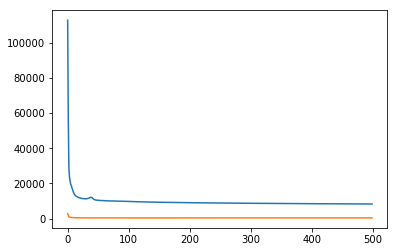

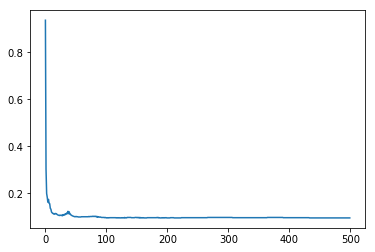

In [2]:
benchmark_full()

Reading in and transforming data...


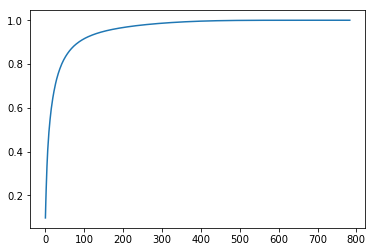

Performing logistic regression...
Cost at iteration 0: 111011.254356
Error rate: 0.894
Cost at iteration 10: 15120.173468
Error rate: 0.115
Cost at iteration 20: 12962.065033
Error rate: 0.112
Cost at iteration 30: 12055.611607
Error rate: 0.11
Cost at iteration 40: 11531.103230
Error rate: 0.109
Cost at iteration 50: 11181.104672
Error rate: 0.106
Cost at iteration 60: 10927.506107
Error rate: 0.103
Cost at iteration 70: 10733.547861
Error rate: 0.099
Cost at iteration 80: 10579.402900
Error rate: 0.098
Cost at iteration 90: 10453.333116
Error rate: 0.097
Cost at iteration 100: 10347.899736
Error rate: 0.097
Cost at iteration 110: 10258.136642
Error rate: 0.095
Cost at iteration 120: 10180.589113
Error rate: 0.095
Cost at iteration 130: 10112.772228
Error rate: 0.095
Cost at iteration 140: 10052.848515
Error rate: 0.096
Cost at iteration 150: 9999.427262
Error rate: 0.096
Cost at iteration 160: 9951.434758
Error rate: 0.095
Cost at iteration 170: 9908.027660
Error rate: 0.095
Cost at 

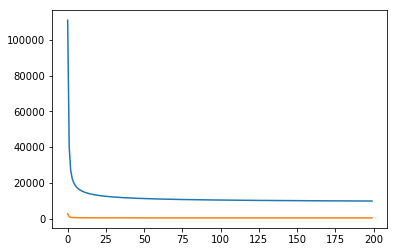

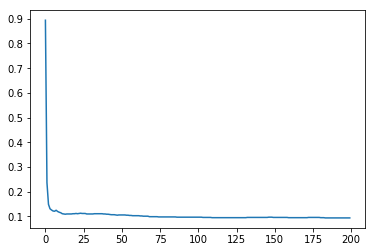

In [3]:
benchmark_pca()